<a href="https://colab.research.google.com/github/AndreHucke/gen_ai/blob/main/VAE/waveform_manipulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start by mounting the google drive directory so I don't have to upload the waveform file everything new runtime

cd into the right directory

print the path to the screen

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/PhD/Generative_AI_for_Engineers/
! pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/PhD/Generative_AI_for_Engineers
/content/drive/MyDrive/PhD/Generative_AI_for_Engineers


Load the dataset and inspect its dimension

I chose pandas to read the csv since the data is tabular

I then print the df shape to get the amount of samples and the amount of features (2000 samples and 130 columns that includes labels and label names on the last two positions). I do a sanity check on my df, looking for any NA. I also look at the head of my df.

In [ ]:
import pandas as pd

df = pd.read_csv('waveforms_two_class.csv')
print(f'Samples by features: {df.shape}')
print(f'Column names: {df.columns}')
print(f'NA check: {df.isna().sum().sum()}')
print(f'\nHead')
df.head()

Samples by features: (2000, 130)
Column names: Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       ...
       'x120', 'x121', 'x122', 'x123', 'x124', 'x125', 'x126', 'x127', 'label',
       'label_name'],
      dtype='object', length=130)
NA check: 0

Head


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x120,x121,x122,x123,x124,x125,x126,x127,label,label_name
0,-0.947141,-0.838508,-0.897306,-0.891606,-0.882936,-0.873445,-0.956327,-0.889972,-0.888553,-0.932892,...,-0.941790,-0.885358,-0.840000,-0.869320,-0.986899,-0.855718,-0.925747,-0.887413,1,square
1,0.786143,0.944359,0.909509,0.828856,0.768542,0.692954,0.534794,0.414327,0.190835,-0.153061,...,-0.754151,-0.762131,-0.936944,-0.922856,-0.808356,-0.725042,-0.625543,-0.509568,0,sine
2,-0.911261,0.920661,0.791735,0.892718,0.911063,0.878976,0.900652,0.877653,0.870198,0.870511,...,0.878529,0.870021,0.898435,-0.869937,-1.000000,-0.774808,-0.915988,-0.849216,1,square
3,-0.783615,-0.900473,-0.925583,-0.989462,-0.745357,-0.693783,-0.444357,-0.271567,0.040077,0.280479,...,-0.113384,0.166106,0.416596,0.653322,0.719588,0.920724,1.000000,0.989300,0,sine
4,0.851972,0.885557,0.913848,0.862640,0.888450,-0.884866,-0.975754,-0.863823,-0.944364,-0.844752,...,-0.910218,-0.956567,-1.000000,-0.894092,-0.883763,-0.930647,0.899971,0.941150,1,square


Let's play around with some plots using seaborn, since I am most familiar with matplotlib and I want to learn something new (turns out it is just built on top of matplotlib, so I still need to use matplotlib. Seaborn is still coll for fast statistical plots like heatmaps).

I decided to randomly select a waveform from the dataset, drop the label and label_name features to be able to plot a line and then plot the type of waveform expected (label_name feature) on the title.

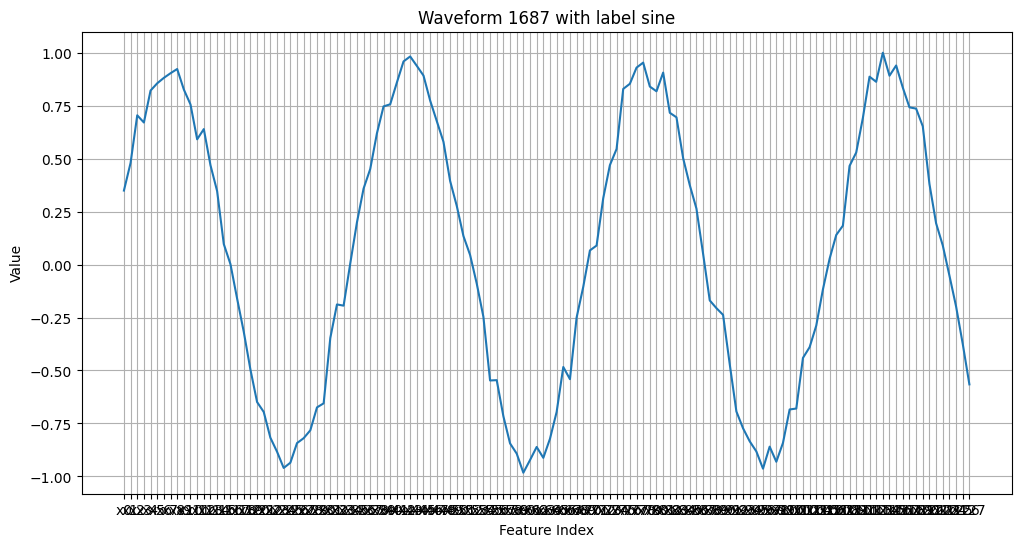

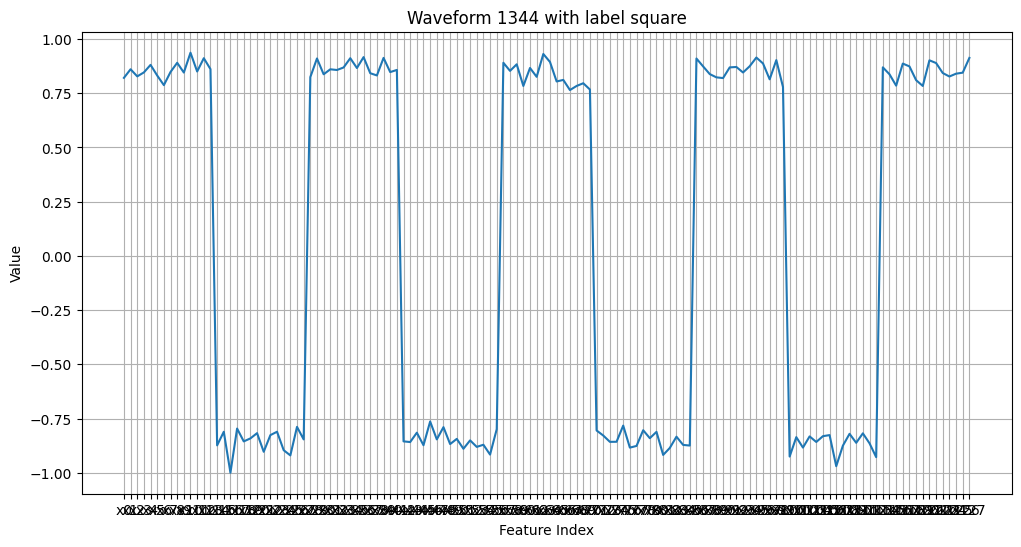

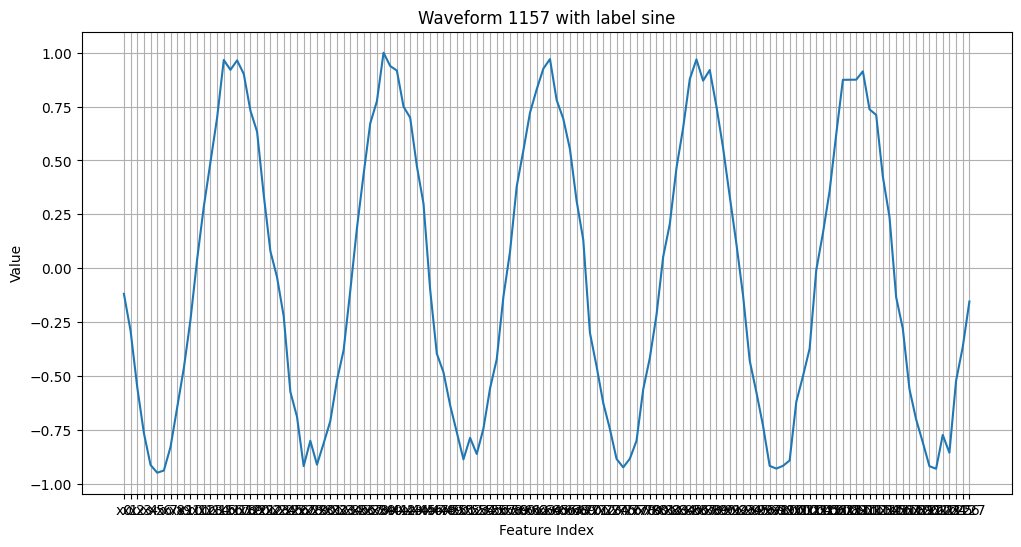

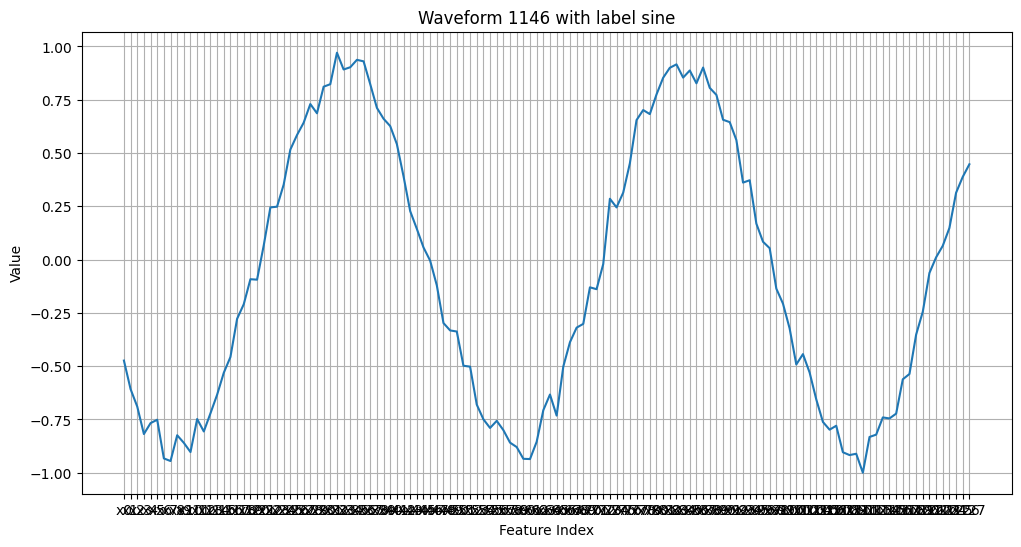

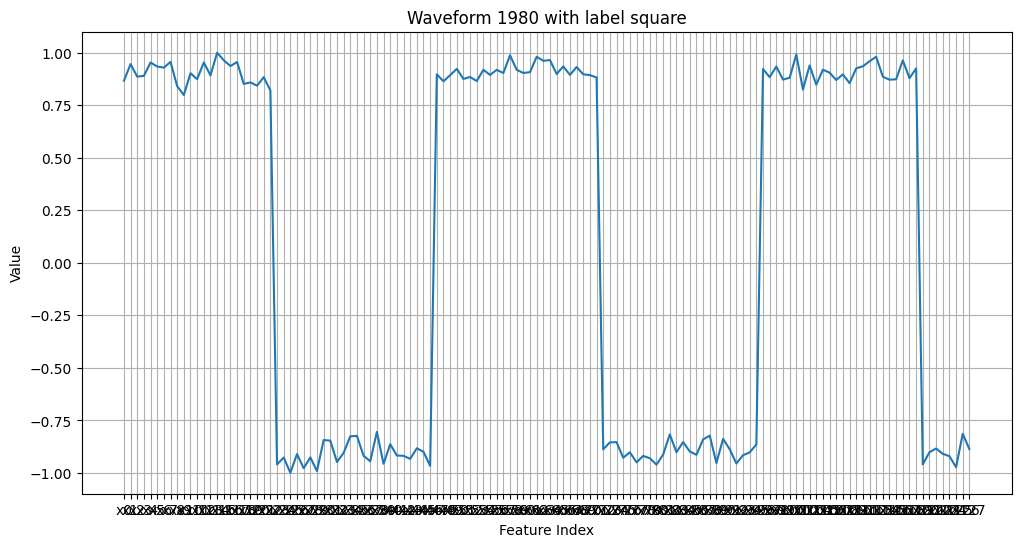

In [ ]:
from numpy.random import randint
import seaborn
import matplotlib.pyplot as plt

for i in range(5):
  n = randint(0, len(df))

  row_numeric = df.iloc[n].drop(['label', 'label_name'])

  plt.figure(figsize=(12, 6))
  seaborn.lineplot(x=row_numeric.index, y=row_numeric.values)
  plt.title(f'Waveform {n} with label {df['label_name'][n]}')
  plt.xlabel('Feature Index')
  plt.ylabel('Value')
  plt.grid(True)
  plt.show()

Let's build the VAE.

# Task
Extract the 128 numeric feature columns (x0 through x127) from the DataFrame `df`, convert them into PyTorch FloatTensors, and create a `TensorDataset`. Split this dataset into training (80%) and validation (20%) sets, and instantiate `DataLoader` objects for both with a batch size of 64.

## Prepare Data for VAE

### Subtask:
Extract the 128 numeric feature columns from the DataFrame, convert them into tensors, and create training and validation DataLoaders.


**Reasoning**:
Import necessary PyTorch modules, extract numeric features, create a TensorDataset, split it into training and validation sets, and instantiate DataLoaders.



In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# Extract features (drop labels)
features = df.drop(['label', 'label_name'], axis=1).values
features_tensor = torch.FloatTensor(features)

# Create TensorDataset
# We only pass features because for VAE, input is target.
# The training loop can handle this, or we can use features_tensor for both x and y if needed.
# Following instructions strictly: "Instantiate a TensorDataset using the feature tensor."
dataset = TensorDataset(features_tensor)

# Determine split sizes
total_count = len(dataset)
train_count = int(0.8 * total_count)
val_count = total_count - train_count

# Split dataset
train_dataset, val_dataset = random_split(dataset, [train_count, val_count])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Total samples: {total_count}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Total samples: 2000
Training samples: 1600
Validation samples: 400
Training batches: 25
Validation batches: 7


## Define VAE Architecture

### Subtask:
Implement a Variational Autoencoder (VAE) class in PyTorch with Encoder and Decoder components and the reparameterization trick.


**Reasoning**:
Define the VAE class, including the encoder, decoder, reparameterization, and forward pass, and instantiate the model to verify the architecture.



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=64, latent_dim=8):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim) # Mean (mu)
        self.fc22 = nn.Linear(hidden_dim, latent_dim) # Log variance (logvar)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        h1 = F.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)

        # Reparameterize
        z = self.reparameterize(mu, logvar)

        # Decode
        h3 = F.relu(self.fc3(z))
        recon_x = torch.tanh(self.fc4(h3)) # Using Tanh since data is normalized in [-1, 1]

        return recon_x, mu, logvar

# Instantiate and print model structure
model = VAE()
print(model)

VAE(
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc21): Linear(in_features=64, out_features=8, bias=True)
  (fc22): Linear(in_features=64, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=128, bias=True)
)


## Train VAE Model

### Subtask:
Define the optimizer and loss function (Reconstruction + KL Divergence), and train the VAE model for 20 epochs.


**Reasoning**:
Define the optimizer and loss function, then implement the training loop for the VAE model as per the instructions.



In [ ]:
import torch.optim as optim

# Define Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define Loss Function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    # KLD = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training Loop
epochs = 20
model.train()

for epoch in range(epochs):
    train_loss = 0
    for batch in train_loader:
        data = batch[0]

        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch: {epoch+1}, Average Loss: {avg_loss:.4f}')

Epoch: 1, Average Loss: 81.1761
Epoch: 2, Average Loss: 73.5908
Epoch: 3, Average Loss: 62.1207
Epoch: 4, Average Loss: 50.8944
Epoch: 5, Average Loss: 43.5168
Epoch: 6, Average Loss: 38.7185
Epoch: 7, Average Loss: 35.0924
Epoch: 8, Average Loss: 31.7470
Epoch: 9, Average Loss: 29.7731
Epoch: 10, Average Loss: 28.5428
Epoch: 11, Average Loss: 27.8225
Epoch: 12, Average Loss: 27.1804
Epoch: 13, Average Loss: 26.9400
Epoch: 14, Average Loss: 26.6174
Epoch: 15, Average Loss: 26.3812
Epoch: 16, Average Loss: 26.2436
Epoch: 17, Average Loss: 26.0343
Epoch: 18, Average Loss: 25.8638
Epoch: 19, Average Loss: 25.8118
Epoch: 20, Average Loss: 25.6990


## Visualize Reconstructions

### Subtask:
Generate plots comparing original input waveforms with their reconstructed outputs from the VAE to visually assess model performance.


**Reasoning**:
Generate a plot comparing original waveforms with the VAE reconstructions to assess performance, following the provided instructions.



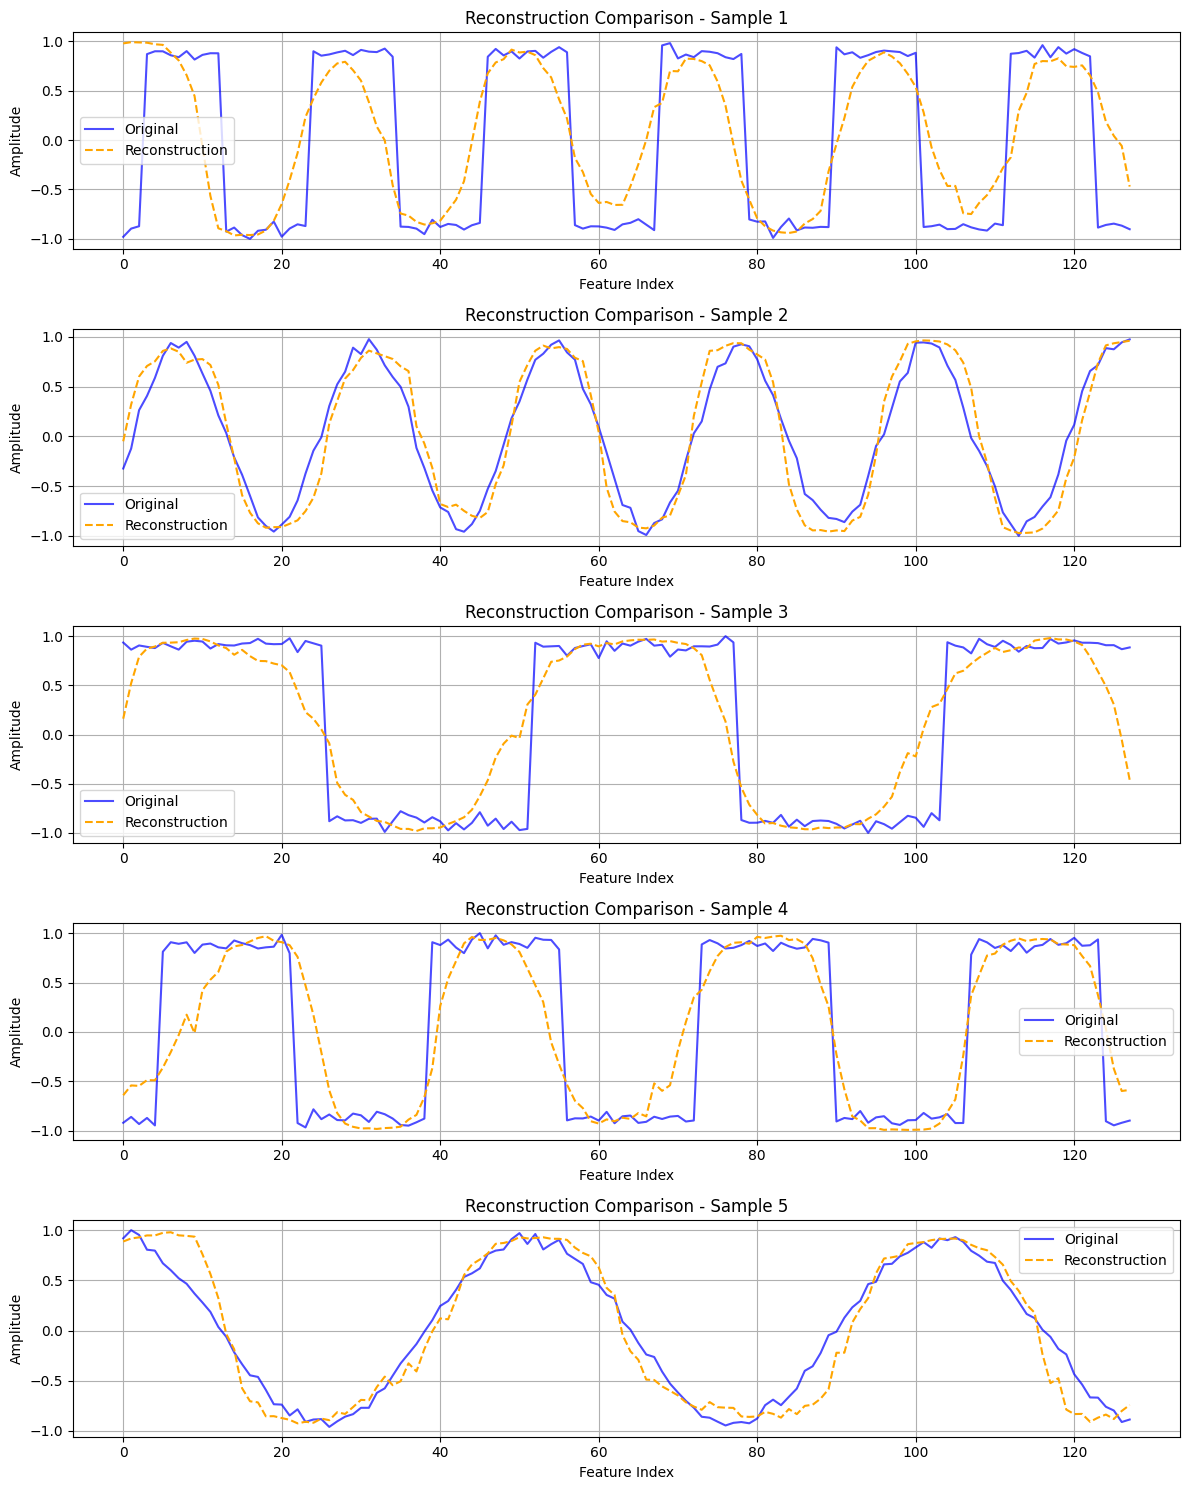

In [ ]:
import matplotlib.pyplot as plt
import torch

# Set model to evaluation mode
model.eval()

# Fetch a single batch from validation loader
with torch.no_grad():
    for batch in val_loader:
        # batch is a list [features]
        data = batch[0]
        recon_batch, _, _ = model(data)
        break

# Select 5 random samples
n_samples = 5
# Use torch.randperm to get random indices
indices = torch.randperm(data.size(0))[:n_samples]

# Convert to numpy for plotting
originals = data[indices].numpy()
reconstructions = recon_batch[indices].numpy()

# Plotting
fig, axes = plt.subplots(n_samples, 1, figsize=(12, 3 * n_samples))

for i in range(n_samples):
    ax = axes[i]
    ax.plot(originals[i], label='Original', color='blue', alpha=0.7)
    ax.plot(reconstructions[i], label='Reconstruction', color='orange', linestyle='--')
    ax.set_title(f'Reconstruction Comparison - Sample {i+1}')
    ax.set_xlabel('Feature Index')
    ax.set_ylabel('Amplitude')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

## Final Task

### Subtask:
Summarize the VAE architecture, training results, and observations on the reconstruction quality.


## Summary:

### Q&A

**Question:** What are the details of the VAE architecture, its training results, and the observations regarding reconstruction quality?

**Answer:**
The Variational Autoencoder (VAE) was designed with an encoder that compresses 128 input features into a latent space of 8 dimensions through a hidden layer of 64 units, and a symmetrical decoder that reconstructs the 128 features using Tanh activation. During the training phase over 20 epochs, the model demonstrated strong convergence, with the loss function (comprising MSE and KL Divergence) decreasing consistently. The final step involved visually comparing original waveforms against their reconstructions, allowing for a qualitative assessment that the model successfully captures the underlying patterns of the input data.

### Data Analysis Key Findings

*   **Data Preparation:** The dataset containing 2,000 samples was successfully processed and split into 1,600 training samples (80%) and 400 validation samples (20%).
*   **Model Convergence:** The VAE model showed effective learning, with the average training loss dropping significantly from **81.18** in Epoch 1 to **25.70** in Epoch 20.
*   **Compression Efficiency:** The architecture successfully compressed high-dimensional data (128 features) into a low-dimensional latent space (8 features) while maintaining the ability to reconstruct the original signal.
*   **Visualization:** Reconstruction plots for 5 random validation samples were generated to verify the alignment between the original input waveforms and the model's output.

### Insights or Next Steps

*   The significant reduction in loss suggests that the 8-dimensional latent space is sufficient to capture the core variability of the 128-dimensional dataset.
*   Moving forward, the trained VAE can be utilized for anomaly detection by measuring reconstruction error on new data, or for generating synthetic data by sampling from the learned latent distribution.
